# Flatiron Phase 4 Project

## Aaron Galbraith

### Submitted: 

# Business Understanding



# Data Understanding

## Import files

Here we'll import all the tools we'll need.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize
from operator import itemgetter
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from nltk import TweetTokenizer
import string
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay

## Load and explore data set

In [2]:
# read csv into dataframe
df = pd.read_csv('../data/tweets.csv', encoding='latin-1')
# show overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# show row and column counts
df.shape

(9093, 3)

In [4]:
# show how many unique values for each feature
df.nunique()

tweet_text                                            9065
emotion_in_tweet_is_directed_at                          9
is_there_an_emotion_directed_at_a_brand_or_product       4
dtype: int64

In [5]:
# show value counts for one feature
df.emotion_in_tweet_is_directed_at.value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [6]:
# show normalized value counts for one feature
round(df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True),2)

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    0.59
Positive emotion                      0.33
Negative emotion                      0.06
I can't tell                          0.02
Name: proportion, dtype: float64

In [7]:
# show breakdown of sentiment labels for tweets that have no product or brand identified
round(df[df.emotion_in_tweet_is_directed_at.isna()] \
.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True),2)

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    0.91
Positive emotion                      0.05
I can't tell                          0.03
Negative emotion                      0.01
Name: proportion, dtype: float64

## Summary of data

There are 9,093 records and three features. It appears that there are some duplicate tweets. For our purposes, even if there were multiple tweets that happened to be identical by chance (rather than duplicated by error), we still don't need both of them.

A little more than one third (3,291) of the tweets are identified as being directed at a particular product or brand associated with either Google or Apple, while the majority do not identify a product or brand.

Relatively few records have been identified as having a negative or "I can't tell" emotion.

For the 5,802 records that don't identify a product or brand, about 9% of them were identified as having something other than "no emotion". One wonders how an emotion was identified if it was not directed at a particular product or brand.

# Data preparation

## Renaming features

The column names are a bit cumbersome, so we'll give them new names that are easier to deal with.

In [8]:
# rename columns
df.rename(columns={'tweet_text': 'text',
                   'emotion_in_tweet_is_directed_at': 'brand',
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'},
          inplace = True)

## Missing values

In [9]:
# show records with missing text
df[df.text.isna()]

,text,brand,sentiment
6,NaN,NaN,No emotion toward brand or product


We can't do anything with a record whose text is missing, so we'll drop it.

In [10]:
# drop records with missing text values
df.dropna(subset=['text'], inplace=True)

## Merge labels and standardize text to lower case

As these tasks may increase the number of duplicate records, we should perform them before we look for those duplicates.

### Lower case

It's not likely that we'll lose anything important by shifting all the text to lower case, especially given the nature of tweeting.

In [11]:
# shift all text to lower case
df['text'] = df['text'].str.lower()

### Merge sentiment

In [12]:
# show breakdown of sentiment before merging
round(df.sentiment.value_counts(normalize=True),2)

sentiment
No emotion toward brand or product    0.59
Positive emotion                      0.33
Negative emotion                      0.06
I can't tell                          0.02
Name: proportion, dtype: float64

In order to reduce the class imbalance and generally simplify the work, we'll change the sentiment labels to a binary system of 1 for positive and 0 for everything else.

In [13]:
# make sentiment binary
df['sentiment'].replace({'No emotion toward brand or product': 0,
                         'Positive emotion': 1,
                         'Negative emotion': 0,
                         "I can't tell": 0
                        }, inplace=True)

In [14]:
# show breakdown of sentiment after merging
round(df.sentiment.value_counts(normalize=True),4)

sentiment
0    0.6725
1    0.3275
Name: proportion, dtype: float64

### Merge brand

In [15]:
# show breakdown of brand before merging
df.brand.value_counts()

brand
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

# POSSIBLE COMMENT OR CHANGE IN STRATEGY HERE DEPENDING ON BUSINESS PROBLEM

In [16]:
# assign either apple or google label and fill in missing values with other
df['brand'].replace(['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'], 'apple',
                     inplace=True)
df['brand'].replace(['Google', 'Other Google product or service', 'Android App', 'Android'], 'google',
                     inplace=True)
df['brand'].fillna('other',
                    inplace=True)

In [17]:
# show breakdown of brand after merging
df.brand.value_counts()

brand
other     5801
apple     2409
google     882
Name: count, dtype: int64

deal with missing company
missing company values are informed by the text, and the text should be all lower case to simplify this
no big deal because we want all lower case for train and test anyway

In [18]:
# make key word lists for apple and google
apple_words = ['ipad', 'apple', 'iphone', 'itunes', 'ipad2']
google_words = ['google', 'android', 'blogger']

In [19]:
# make a function that relabels brand values by finding what keywords are mentioned in the text
def brand_fix(text, brand):
    # only relabel records that do not have one of the two brands already associated
    if brand != 'other':
        return brand
    else:
        apple, google = False, False
        # look for apple keyword
        for word in apple_words:
            if word in text:
                apple = True
                break
        # look for google keyword
        for word in google_words:
            if word in text:
                google = True
                break

        # return correct new label
        if apple & ~google:
            return 'apple'
        elif google & ~apple:
            return 'google'
        elif apple & google:
            return 'both'
        else:
            return 'neither'

In [20]:
# run above function to relabel brand values
df['brand'] = df.apply(lambda x: brand_fix(x.text, x.brand), axis=1)
# show breakdown of brand after running function
df.brand.value_counts()

brand
apple      5396
google     2804
neither     704
both        188
Name: count, dtype: int64

# CONSIDER REVISITING "NEITHER" AND "BOTH" DEPENDING ON BUSINESS PROBLEM

## Duplicates

In [21]:
# show how many records are duplicates
df.duplicated().value_counts()

False    9050
True       42
Name: count, dtype: int64

We'll drop any duplicate records.

In [22]:
# drop duplicate records
df.drop_duplicates(inplace=True)

In [23]:
# show how many records are duplicates for the text value only
df.duplicated(subset=['text']).value_counts()

False    9047
True        3
Name: count, dtype: int64

Curiously, a few records are identified as duplicate text values that evidently have different values for other features. Let's see if those records differ on sentiment identification. (It's less important whether they differ on brand identification.)

In [24]:
# show sentiment identification for groups of duplicated tweets
for i, index in enumerate(df[df.duplicated(subset=['text'])].index):
    print(
        'duplicate group', i+1, '\n',
        df.loc[index].text, '\n\n',
        df[df.text == df.loc[index].text].sentiment.value_counts(),
        '\n\n- - - -\n'
    )

duplicate group 1 
 win free ipad 2 from webdoc.com #sxsw rt 

 sentiment
0    1
1    1
Name: count, dtype: int64 

- - - -

duplicate group 2 
 rt @mention marissa mayer: google will connect the digital &amp; physical worlds through mobile - {link} #sxsw 

 sentiment
1    1
0    1
Name: count, dtype: int64 

- - - -

duplicate group 3 
 rt @mention rt @mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link} 

 sentiment
1    1
0    1
Name: count, dtype: int64 

- - - -



Each duplicated tweet has been labeled once as positive and once as nonpositive. It seems fair to keep the positive labels for each of these.

In [25]:
# iterate over records listed as duplicates
for i in df[df.duplicated(subset=['text'])].index:
    # drop any records whose text matches a particular duplicate AND is labeled nonpositive
    df.drop(df[ (df.text == df.loc[i].text) & (df.sentiment == 0) ].index, inplace=True)

## I don't know what to call this yet

I'm going to repeat some tokenizing code that appears further down.

In [26]:
corpus = df.text.to_list()

In [27]:
# make tokenizer
tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True
)

In [28]:
tokens = tokenizer.tokenize(','.join(corpus))

In [29]:
corpus

['.@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead!  i need to upgrade. plugin stations at #sxsw.',
 "@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",
 '@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.',
 "@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw",
 "@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",
 '@teachntech00 new ipad apps for #speechtherapy and communication are showcased at the #sxsw conference http://ht.ly/49n4m #iear #edchat #asd',
 '#sxsw is just starting, #ctia is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'beautifully smart and simple idea rt @madebymany @thenextweb wrote about our #hollergram ipad app for #sxsw! http://bit.ly/ieav

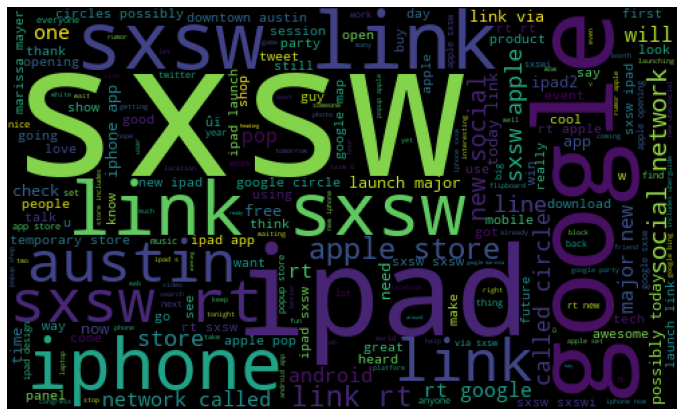

In [30]:
# instantiate wordcloud
wordcloud = WordCloud(
    width=500,
    height=300
)

# generate wordcloud
wordcloud.generate(','.join(tokens))

# plot wordcloud

plt.figure(figsize = (12, 15), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off');

In [ ]:
# create feature of tokenized text
df.loc[:, 'text_tokenized'] = df['text'].apply(tokenizer.tokenize)
# make vocabulary from set of words
vocab_raw = set(df['text_tokenized'].explode())
# show size of raw vocabulary
print('Size of raw vocabulary:', len(vocab_raw))   

## Train and test sets

In [ ]:
# split the data into target (sentiment) and predictor (text)
X, y = df['text'].to_frame(), df['sentiment']
# split the data into train and test sets
# set random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# REVISIT THIS

add label to X_train for research purposes .. obviously don't include this in the model

reset index to anticipate future problems ... or not reset the index???

In [ ]:
X_train.loc[:, 'sentiment'] = [y_train.loc[val] for val in X_train.index]

## Tokenize

We'll establish a token pattern that will separate each tweet into a list of tokens at least 2 letters long and ignore punctuation characters.

In [ ]:
# make tokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

We'll make a new column whose values will be the list of tokens from each text value. Then we can group these tokens/words together into a vocabulary.

In [ ]:
# create feature of tokenized text
X_train.loc[:, 'text_tokenized'] = X_train['text'].apply(tokenizer.tokenize)
# make vocabulary from set of words
vocab_raw = set(X_train['text_tokenized'].explode())
# show size of raw vocabulary
print('Size of raw vocabulary:', len(vocab_raw))   

# Modeling

## Baseline model

We'll use multinomial naive Bayes for our baseline model and feed it the 10 most common tokens.

In [ ]:
# instantiate model
baseline_model = MultinomialNB()

It will be instructive to recall the percentage of the plurality in the target feature (sentiment). Models should be evaluated in relation to this.

In [ ]:
# save this value to compare to future model crossval scores
plurality_cv = round(y_train.value_counts(normalize=True)[0],4)
# show the sentiment breakdown
round(y_train.value_counts(normalize=True),4)

Accuracy of future models should exceed the higher of these values, since we know that, at worst, a model could just predict all sentiments are "nonpositive" and achieve this accuracy score.

We'll run the first model and compare the score to this plurality.

In [ ]:
tfidf = TfidfVectorizer(
    max_features = 10
)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

baseline_cv = round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4)

print('Plurality:', plurality_cv,
      '\nBaseline: ',baseline_cv)

This did not improve on plurality at all.

Let's look at what words it was using.

In [ ]:
def plot_words(column, title):

    fig = plt.figure(figsize=(15, 5))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0, :1])
    ax2 = fig.add_subplot(gs[0, 1:2])

    axes = [ax1, ax2]

    for index, category in enumerate(y_train.unique()):

        all_words = X_train[X_train['sentiment'] == category][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]

        ax = axes[index]
        ax.bar(tokens, counts)

        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)

In [ ]:
plot_words('text_tokenized', 'sentiment =')

It's not surprising that these words did not yield useful results, as they're very common.

## All words model

We'll see if anything changes when we feed the model all possible tokens rather than just the 10 most common ones.

In [ ]:
tfidf = TfidfVectorizer()

X_train_vectorized = tfidf.fit_transform(X_train['text'])

all_words_cv = round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4)

print('Plurality:', plurality_cv,
      '\nBaseline: ',baseline_cv,
      '\nAll Words:',all_words_cv
     )

This did indeed improve the accuracy.

Let's see what words it scored as most useful by their tfidf scores.

In [ ]:
# create the word list from this vectorizer with new index
feature_names = np.array(tfidf.get_feature_names())
# create array of the indices of the feature_names array, ordered by tfidf score
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
# create frequency distribution (dictionary) of 1-grams
all_words_freq_dist = FreqDist(X_train['text_tokenized'].explode())

In [ ]:
# show the words with the top 10 tfidf values, and their tfidf values
print('10 most useful words', '\n\ntfidf | frequency | word\n')
for n in range(-1,-11,-1):
    index = sorted_tfidf_index[n]
    print(
        round(X_train_vectorized.max(0).toarray()[0][index],4),
        all_words_freq_dist[feature_names[index]],
        feature_names[index]
         )
# show the words with the bottom 5 tfidf values, and their tfidf values
print('\n5 least useful words', '\n\ntfidf | frequency | word\n')
for n in range(5):
    index = sorted_tfidf_index[n]
    print(
        round(X_train_vectorized.max(0).toarray()[0][index],4),
        all_words_freq_dist[feature_names[index]],
        feature_names[index]
         )      

## Stemmed and lemmatized model

Now we'll stem and lemmatize the tokens.

In [ ]:
# instantiate a stemmer and lemmatizer
stemmer = SnowballStemmer(language="english")
lemmatizer = WordNetLemmatizer()

In [ ]:
# make a function that tokenizes, stems and lemmatizes a document
def stem_and_lemmatize_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(stemmer.stem(token)) for token in tokens]

In [ ]:
# create a column whose values are a list of stemmed and lemmatized words
X_train.loc[:, 'stem_lemma_list'] = X_train.loc[:, 'text'].apply(stem_and_lemmatize_and_tokenize)
# make vocabulary from set of words
vocab_stemmed_and_lemmatized = set(X_train['stem_lemma_list'].explode())
# compare vocabulary sizes
print('Size of raw vocabulary:                   ', len(vocab_raw),
      '\nSize of stemmed and lemmatized vocabulary:', len(vocab_stemmed_and_lemmatized)
     )

The stemmed and lemmatized vocabulary is significantly smaller. We can now investigate whether this has introduced new duplicate values for the stemmed and lemmatized text.

The feature we just created contains *lists* of lemmatized words. In order to find out whether we have duplicates, we'll need to reassemble 

In [ ]:
X_train.duplicated(subset=['stem_lemma_list']).value_counts()

# WHAT TO DO ABOUT NEW DUPLICATES?

In [ ]:
tfidf = TfidfVectorizer(
    tokenizer = stem_and_lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

stemmed_and_lemmatized_words_cv = round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4)

print('Baseline:                    ',baseline_cv,
      '\nAll Words:                   ',all_words_cv,
      '\nStemmed and Lemmatized Words:', stemmed_and_lemmatized_words_cv
     )

It appears that feeding it lemmatized words just slightly decreased accuracy.

We know that the top 10 baseline model suffered because the most frequent words were useless. Let's experiment with a maximum document frequency.

In [ ]:
max_df_vals = np.linspace(1/100, 1, 100)
max_df_scores = []
for max_df in max_df_vals:
    tfidf = TfidfVectorizer(
        max_df = max_df
    )

    X_train_vectorized = tfidf.fit_transform(X_train['text'])

    max_df_scores.append(round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4))


In [ ]:
plt.scatter(max_df_vals, max_df_scores)
plt.ticklabel_format(axis='both', style='plain')

In [ ]:
tfidf = TfidfVectorizer(
    tokenizer = stem_and_lemmatize_and_tokenize,
    min_df = 2,
    max_df = .02
)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

stemmed_and_lemmatized_words_cv = round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4)

print('Plurality:                   ', plurality_cv,
      '\nStemmed and Lemmatized Words:', stemmed_and_lemmatized_words_cv
     )